In [1]:
import pypsa
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import gurobipy as gp
import seaborn as sns
import pyomo.environ as pyo
import os

In [3]:
solar_data = pd.read_csv('solargenerationyear2023rev5.csv', delimiter=';')
prices_data = pd.read_csv('electricitypricesyear2023rev1.csv', delimiter=';')
load_data = pd.read_csv('loaddata2023rev3.csv', delimiter=';')
BM_prices_data = pd.read_csv('BMprices2023rev1.csv', delimiter=';')
strike_price = 55

In [5]:
prices_data['datetime'] = pd.to_datetime(prices_data['datetime'], format='%d/%m/%y %H.%M')
prices_data.set_index('datetime', inplace=True)
prices_data.replace([np.inf, -np.inf], np.nan, inplace=True)
prices_data_ffill  = prices_data.ffill()
prices_data = prices_data.resample('H').mean()

load_data['datetime'] = pd.to_datetime(load_data['datetime'], format='%d/%m/%y %H.%M')
load_data.set_index('datetime', inplace=True)
load_data.replace([np.inf, -np.inf], np.nan, inplace=True)
load_data = load_data.resample('H').mean()

In [7]:
BM_prices_data['datetime'] = pd.to_datetime(BM_prices_data['datetime'], format='%d/%m/%y %H.%M')
BM_prices_data.set_index('datetime', inplace=True)
BM_prices_data.replace([np.inf, -np.inf], np.nan, inplace=True)
BM_prices_data = BM_prices_data.resample('H').mean()

In [9]:
solar_data['timestamp'] = solar_data['date'] + solar_data['time']
solar_data = solar_data.drop(['date', 'time'], axis=1)

solar_data.to_csv('combined_data.csv', index=False)
solar_data['timestamp'] = pd.to_datetime(solar_data['timestamp'], format='%d-%m-%Y%H.%M.%S')
solar_data.set_index('timestamp', inplace=True)

In [11]:
network = pypsa.Network()

hours_in_year = pd.date_range("2022-01-01 00:00", "2022-12-31 23:00", freq="H")
network.set_snapshots(hours_in_year)

network.add("Bus", "Solar")
network.add("Bus", "Battery")
network.add("Bus", "Grid")

network.add("Load",
            "load",
            bus="Grid",
            p_set=load_data['demand'].values)

network.add("Generator", 
            "solar", 
            bus="Solar",
            p_nom=20,
            lifetime=20,
            p_set=solar_data['generation'].values,
            capital_cost=0,
            marginal_cost=0,
            p_nom_extendable=True,
            carrier="solar",
           )

network.add("Generator",
            "Backup Generator",
            bus="Grid",
            capital_cost=1000000,
            marginal_cost=prices_data['prices'].values,
            p_nom_extendable=True,
            )

network.add("StorageUnit",
            "battery",
            bus="Battery",
            lifetime=10, 
            marginal_cost=0,
            max_hours=2,
            state_of_charge_initial=0,
            p_nom_extendable=True,
            cyclic_state_of_charge=True,
            capital_cost=700000,#perMW
            efficiency_store=0.95,
            efficiency_dispatch=0.95)

network.add("Link", "solar_grid", bus0="Solar", bus1="Grid", p_nom=20, marginal_cost=0)
network.add("Link", "solar_battery", bus0="Solar", bus1="Battery", p_nom=20)
network.add("Link", "battery_grid", bus0="Battery", bus1="Grid", p_nom=20, marginal_cost=0)
network.add("Link", "grid_battery", bus0="Grid", bus1="Battery", p_nom=20, marginal_cost=1)

In [13]:
# Create the model instance
network.optimize.create_model()

# Modify the model to include the custom constraint
def extra_functionality(n, snapshots):
    from linopy import Model

    m = n.model

    # Retrieve the link power variables
    link_p = m.variables['Link-p']

    # Define the constraint for each snapshot
    max_export_constraints = (
        link_p[:, n.links.index.get_loc("solar_grid")] + link_p[:, n.links.index.get_loc("battery_grid")] <= 20
    )
    
    m.add_constraints(max_export_constraints, name="max_export_constraints")

# Solve the modified model with the custom constraint
network.optimize.solve_model(solver_name='gurobi', extra_functionality=extra_functionality)

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████████| 7/7 [00:00<00:00, 64.83it/s]
INFO:linopy.io: Writing time: 0.83s


Read LP format model from file /private/var/folders/ng/xnmfplc57n51cnr7htdqb6g00000gn/T/linopy-problem-dbqxl5dz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ng/xnmfplc57n51cnr7htdqb6g00000gn/T/linopy-problem-dbqxl5dz.lp


Reading time = 0.41 seconds


INFO:gurobipy:Reading time = 0.41 seconds


obj: 210243 rows, 78843 columns, 367923 nonzeros


INFO:gurobipy:obj: 210243 rows, 78843 columns, 367923 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 210243 rows, 78843 columns and 367923 nonzeros


INFO:gurobipy:Optimize a model with 210243 rows, 78843 columns and 367923 nonzeros


Model fingerprint: 0x3da28895


INFO:gurobipy:Model fingerprint: 0x3da28895


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [5e-03, 1e+06]


INFO:gurobipy:  Objective range  [5e-03, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-02, 2e+03]


INFO:gurobipy:  RHS range        [2e-02, 2e+03]


Presolve removed 166435 rows and 35047 columns


INFO:gurobipy:Presolve removed 166435 rows and 35047 columns


Presolve time: 0.33s


INFO:gurobipy:Presolve time: 0.33s


Presolved: 43808 rows, 43796 columns, 122664 nonzeros


INFO:gurobipy:Presolved: 43808 rows, 43796 columns, 122664 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.642e+04


INFO:gurobipy: AA' NZ     : 9.642e+04


 Factor NZ  : 4.818e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.818e+05 (roughly 40 MB of memory)


 Factor Ops : 6.116e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.116e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.98319097e+09 -8.76762951e+09  3.54e+02 3.50e-12  6.38e+06     1s


INFO:gurobipy:   0   3.98319097e+09 -8.76762951e+09  3.54e+02 3.50e-12  6.38e+06     1s


   1   3.99086001e+09 -8.13402414e+09  8.37e+01 1.87e+03  8.24e+05     1s


INFO:gurobipy:   1   3.99086001e+09 -8.13402414e+09  8.37e+01 1.87e+03  8.24e+05     1s


   2   3.93870354e+09 -3.54706987e+09  1.28e+01 1.57e+02  1.44e+05     1s


INFO:gurobipy:   2   3.93870354e+09 -3.54706987e+09  1.28e+01 1.57e+02  1.44e+05     1s


   3   3.86865115e+09  3.05888052e+09  1.73e+00 1.95e-09  9.50e+03     1s


INFO:gurobipy:   3   3.86865115e+09  3.05888052e+09  1.73e+00 1.95e-09  9.50e+03     1s


   4   3.66555493e+09  3.41751607e+09  1.27e-01 1.89e-09  2.84e+03     1s


INFO:gurobipy:   4   3.66555493e+09  3.41751607e+09  1.27e-01 1.89e-09  2.84e+03     1s


   5   3.64348036e+09  3.52212313e+09  9.43e-02 2.44e-10  1.39e+03     1s


INFO:gurobipy:   5   3.64348036e+09  3.52212313e+09  9.43e-02 2.44e-10  1.39e+03     1s


   6   3.58818774e+09  3.55229057e+09  2.23e-02 2.65e-09  4.10e+02     1s


INFO:gurobipy:   6   3.58818774e+09  3.55229057e+09  2.23e-02 2.65e-09  4.10e+02     1s


   7   3.58399894e+09  3.56604401e+09  1.74e-02 4.07e-10  2.05e+02     1s


INFO:gurobipy:   7   3.58399894e+09  3.56604401e+09  1.74e-02 4.07e-10  2.05e+02     1s


   8   3.58548636e+09  3.56703604e+09  1.69e-02 1.16e-10  2.11e+02     1s


INFO:gurobipy:   8   3.58548636e+09  3.56703604e+09  1.69e-02 1.16e-10  2.11e+02     1s


   9   3.58288828e+09  3.57704773e+09  2.31e-03 4.07e-10  6.67e+01     1s


INFO:gurobipy:   9   3.58288828e+09  3.57704773e+09  2.31e-03 4.07e-10  6.67e+01     1s


  10   3.58211731e+09  3.58025243e+09  7.54e-04 4.37e-10  2.13e+01     1s


INFO:gurobipy:  10   3.58211731e+09  3.58025243e+09  7.54e-04 4.37e-10  2.13e+01     1s


  11   3.58162770e+09  3.58096969e+09  1.96e-04 2.60e-11  7.51e+00     1s


INFO:gurobipy:  11   3.58162770e+09  3.58096969e+09  1.96e-04 2.60e-11  7.51e+00     1s


  12   3.58142022e+09  3.58120974e+09  6.04e-05 1.16e-10  2.40e+00     1s


INFO:gurobipy:  12   3.58142022e+09  3.58120974e+09  6.04e-05 1.16e-10  2.40e+00     1s


  13   3.58135510e+09  3.58127543e+09  2.11e-05 6.40e-10  9.10e-01     1s


INFO:gurobipy:  13   3.58135510e+09  3.58127543e+09  2.11e-05 6.40e-10  9.10e-01     1s


  14   3.58133696e+09  3.58129907e+09  4.15e-05 1.16e-10  4.33e-01     1s


INFO:gurobipy:  14   3.58133696e+09  3.58129907e+09  4.15e-05 1.16e-10  4.33e-01     1s


  15   3.58132577e+09  3.58130943e+09  1.02e-04 2.33e-10  1.87e-01     1s


INFO:gurobipy:  15   3.58132577e+09  3.58130943e+09  1.02e-04 2.33e-10  1.87e-01     1s


  16   3.58131959e+09  3.58131467e+09  7.20e-05 3.20e-10  5.67e-02     1s


INFO:gurobipy:  16   3.58131959e+09  3.58131467e+09  7.20e-05 3.20e-10  5.67e-02     1s


  17   3.58131671e+09  3.58131574e+09  2.58e-05 1.19e-09  1.12e-02     1s


INFO:gurobipy:  17   3.58131671e+09  3.58131574e+09  2.58e-05 1.19e-09  1.12e-02     1s


  18   3.58131615e+09  3.58131592e+09  1.21e-05 1.66e-09  2.76e-03     1s


INFO:gurobipy:  18   3.58131615e+09  3.58131592e+09  1.21e-05 1.66e-09  2.76e-03     1s


  19   3.58131604e+09  3.58131599e+09  5.40e-06 6.98e-10  6.36e-04     1s


INFO:gurobipy:  19   3.58131604e+09  3.58131599e+09  5.40e-06 6.98e-10  6.36e-04     1s


  20   3.58131603e+09  3.58131603e+09  1.78e-06 2.12e-11  1.75e-05     1s


INFO:gurobipy:  20   3.58131603e+09  3.58131603e+09  1.78e-06 2.12e-11  1.75e-05     1s


  21   3.58131603e+09  3.58131603e+09  3.10e-08 5.90e-11  7.26e-08     1s


INFO:gurobipy:  21   3.58131603e+09  3.58131603e+09  3.10e-08 5.90e-11  7.26e-08     1s


  22   3.58131603e+09  3.58131603e+09  7.78e-11 2.59e-08  7.26e-11     2s


INFO:gurobipy:  22   3.58131603e+09  3.58131603e+09  7.78e-11 2.59e-08  7.26e-11     2s


INFO:gurobipy:


Barrier solved model in 22 iterations and 1.54 seconds (1.03 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 1.54 seconds (1.03 work units)


Optimal objective 3.58131603e+09


INFO:gurobipy:Optimal objective 3.58131603e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8012 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    8012 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       2 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       2 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2315524e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2315524e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 712


INFO:gurobipy:Extra simplex iterations after uncrush: 712


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8680    3.5813160e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8680    3.5813160e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8680 iterations and 1.78 seconds (1.34 work units)


INFO:gurobipy:Solved in 8680 iterations and 1.78 seconds (1.34 work units)


Optimal objective  3.581316028e+09


INFO:gurobipy:Optimal objective  3.581316028e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78843 primals, 210243 duals
Objective: 3.58e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, max_export_constraints were not assigned to the network.


('ok', 'optimal')

In [17]:
# Access optimized values
initial_pv_nom_opt = network.generators.p_nom_opt['solar']
initial_battery_nom_opt = network.storage_units.p_nom_opt['battery']
battery_max_hours = network.storage_units.at["battery", "max_hours"]
battery_capacity = initial_battery_nom_opt * battery_max_hours
back_up_generator = network.generators.p_nom_opt['Backup Generator']

# Flows
solar_grid_flow = network.links_t.p0["solar_grid"]
solar_battery_flow = network.links_t.p0["solar_battery"]
battery_grid_flow = network.links_t.p0["battery_grid"]
grid_battery_flow = network.links_t.p0["grid_battery"]
soc = network.storage_units_t.state_of_charge["battery"]
soc_percentage = (soc / battery_capacity) * 100

# Total energy flow
total_solar_grid = solar_grid_flow.sum()
total_solar_battery = solar_battery_flow.sum()
total_battery_grid = battery_grid_flow.sum()
total_grid_battery = grid_battery_flow.sum()


# Total energy generated by PV
energy_generated_pv = network.generators_t.p["solar"]
total_energy_generated_pv = network.generators_t.p["solar"].sum()

# Total energy discharged by the battery over the year (in MWh)
total_energy_discharged_battery = network.storage_units_t.p_dispatch["battery"].sum()

# Total energy charged by the battery over the year (in MWh)
total_energy_charged_battery = network.storage_units_t.p_store["battery"].sum()

arbitrage_state_of_charge = network.storage_units_t.state_of_charge["battery"].copy()
arbitrage_p_dispatch = network.storage_units_t.p_dispatch["battery"].copy()
arbitrage_p_store = network.storage_units_t.p_store["battery"].copy()

# Create a DataFrame to save the results
results = {
    "Initial Optimal Battery Size (MW)": [initial_battery_nom_opt],
    "Initial Optimal Battery Capacity (MWh)": [battery_capacity],
    "Initial Solar Size (MW)": [initial_pv_nom_opt],
    "Backup Generator Size (MW)": [back_up_generator],
    "Total Solar to Grid (MWh)": [total_solar_grid],
    "Total Solar to Battery (MWh)": [total_solar_battery],
    "Total Battery to Grid (MWh)": [total_battery_grid],
    "Total Grid to Battery (MWh)": [total_grid_battery],
    "Total Energy Generated by PV (MWh)": [total_energy_generated_pv],
    "Total Energy Discharged by Battery (MWh)": [total_energy_discharged_battery],
    "Total Energy Charged by Battery (MWh)": [total_energy_charged_battery]
}

results_df = pd.DataFrame(results)

# Save the state of charge, dispatch, and store data to separate sheets
with pd.ExcelWriter("3busessetlink2023most.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="Summary", index=False)
    energy_generated_pv.to_frame(name="Solar generated").to_excel(writer, sheet_name="Solar generated")
    solar_grid_flow.to_frame(name="Solar to Grid (MW)").to_excel(writer, sheet_name="Solar to Grid")
    solar_battery_flow.to_frame(name="Solar to Battery (MW)").to_excel(writer, sheet_name="Solar to Battery")
    battery_grid_flow.to_frame(name="Battery to Grid (MW)").to_excel(writer, sheet_name="Battery to Grid")
    grid_battery_flow.to_frame(name="Grid to Battery (MW)").to_excel(writer, sheet_name="Grid to Battery")
    soc.to_frame(name="State of Charge (MWh)").to_excel(writer, sheet_name="State of Charge")
    soc_percentage.to_frame(name="State of Charge (%)").to_excel(writer, sheet_name="State of Charge %")
    arbitrage_p_dispatch.to_frame(name="Battery Dispatch (MW)").to_excel(writer, sheet_name="Battery Dispatch")
    arbitrage_p_store.to_frame(name="Battery Store (MW)").to_excel(writer, sheet_name="Battery Store")

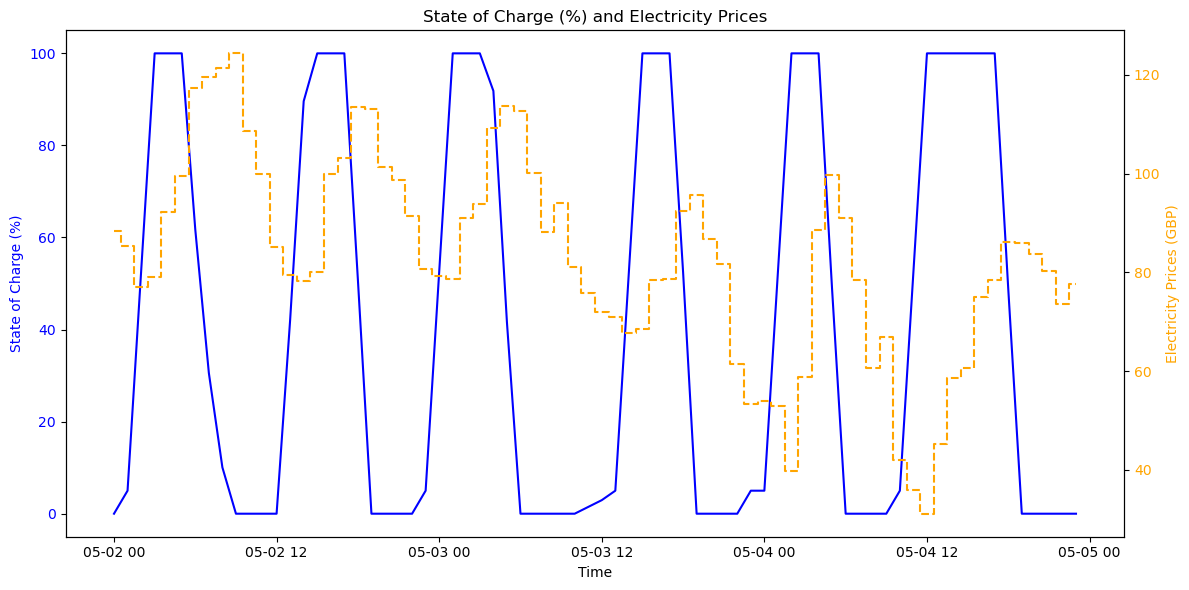

In [19]:
soc = arbitrage_state_of_charge
prices = prices_data.loc[network.snapshots, "prices"]

# Calculate the maximum capacity of the battery
max_capacity = network.storage_units.at['battery', 'p_nom_opt'] * network.storage_units.at['battery', 'max_hours']

# Convert SoC to percentage
soc_percentage = (soc / max_capacity) * 100

start_date = "2022-05-02"
end_date = "2022-05-04"
    
# Filter the data for the specific time range
soc_filtered = soc_percentage.loc[start_date:end_date]
prices_filtered = prices.loc[start_date:end_date]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot State of Charge (SoC) percentage with the first y-axis
ax1.plot(soc_filtered.index, soc_filtered.values, label='State of Charge (SoC) %', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('State of Charge (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot prices
ax2 = ax1.twinx()
ax2.step(prices_filtered.index, prices_filtered.values, label='Electricity Prices (GBP/MWh)', color='orange', where='mid', linestyle="--")
ax2.set_ylabel('Electricity Prices (GBP)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and legend
plt.title(f'State of Charge (%) and Electricity Prices')
fig.tight_layout()

# Show the plot
plt.show()

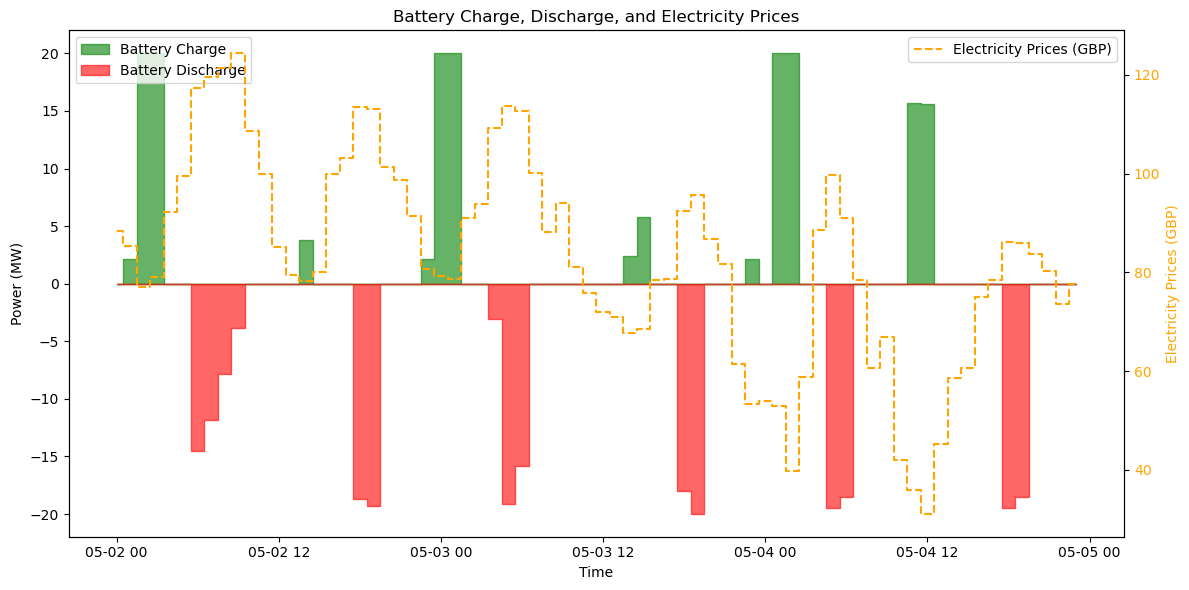

In [21]:
battery_charge = network.storage_units_t.p_store["battery"]
battery_discharge = arbitrage_p_dispatch
prices = prices_data.loc[network.snapshots, "prices"]
charge_flow = network.links_t.p0["grid_battery"]

# Define the start and end dates for the plot
start_date = "2022-05-02"
end_date = "2022-05-04"
    
# Filter the data for the specific time range
battery_charge_filtered = charge_flow.loc[start_date:end_date]
battery_discharge_filtered = battery_discharge.loc[start_date:end_date]
prices_filtered = prices.loc[start_date:end_date]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Battery Charge and Discharge with the first y-axis
ax1.fill_between(battery_charge_filtered.index, 0, battery_charge_filtered.values, label='Battery Charge', color='green', step='mid', alpha=0.6)
ax1.fill_between(battery_discharge_filtered.index, 0, -battery_discharge_filtered.values, label='Battery Discharge', color='red', step='mid', alpha=0.6)
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (MW)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Create a second y-axis to plot prices
ax2 = ax1.twinx()
ax2.step(prices_filtered.index, prices_filtered.values, label='Electricity Prices (GBP)', color='orange', where='mid', linestyle="--")
ax2.set_ylabel('Electricity Prices (GBP)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Add a title and tight layout
plt.title('Battery Charge, Discharge, and Electricity Prices')
fig.tight_layout()

# Show the plot
plt.show()

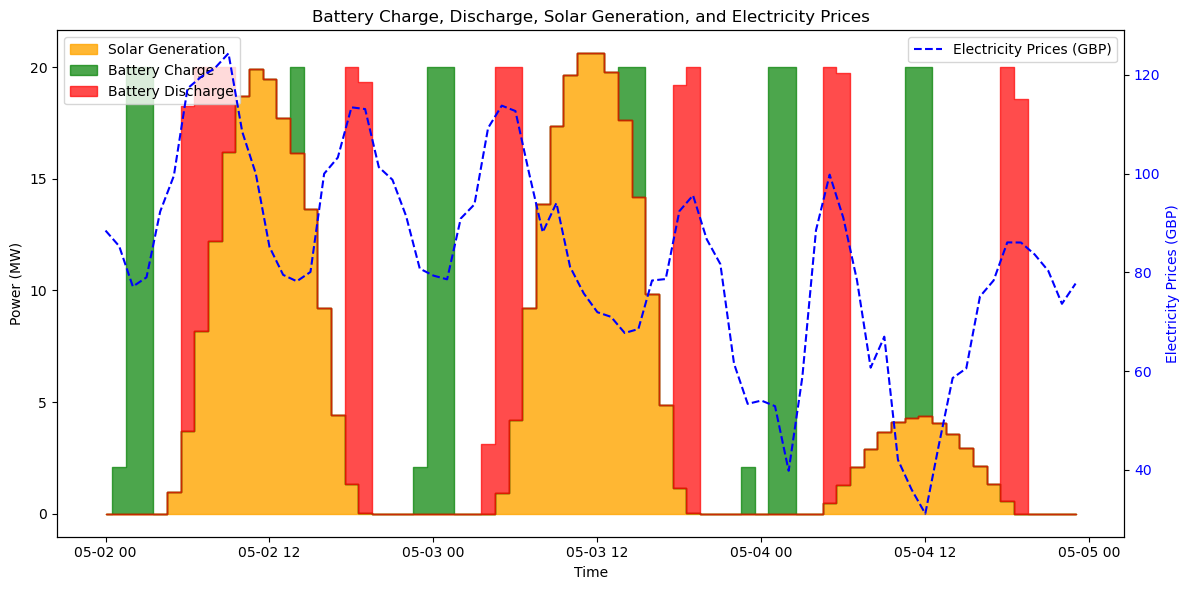

In [23]:
import matplotlib.pyplot as plt
charge_flow = link_charge
battery_discharge = arbitrage_p_dispatch
prices = prices_data.loc[network.snapshots, "prices"]
solar_generation = network.generators_t.p["solar"]
# Define the start and end dates for the plot
start_date = "2022-05-02"
end_date = "2022-05-04"
    
# Filter the data for the specific time range
charge_flow_filtered = charge_flow.loc[start_date:end_date]
discharge_filtered = arbitrage_p_dispatch.loc[start_date:end_date]
prices_filtered = prices.loc[start_date:end_date]
solar_generation_filtered = solar_generation.loc[start_date:end_date]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Stacked area plot for Solar Generation and Battery Charge/Discharge
ax1.fill_between(solar_generation_filtered.index, 0, solar_generation_filtered.values, label='Solar Generation', color='orange', step='mid', alpha=0.8)
ax1.fill_between(charge_flow_filtered.index, solar_generation_filtered.values, solar_generation_filtered.values + charge_flow_filtered.values, label='Battery Charge', color='green', step='mid', alpha=0.7)
ax1.fill_between(discharge_filtered.index, solar_generation_filtered.values, solar_generation_filtered.values + discharge_filtered.values, label='Battery Discharge', color='red', step='mid', alpha=0.7)


# Plot customization
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (MW)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Create a second y-axis to plot prices
ax2 = ax1.twinx()
ax2.plot(prices_filtered.index, prices_filtered.values, label='Electricity Prices (GBP)', color='blue', linestyle='--')
ax2.set_ylabel('Electricity Prices (GBP)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

# Add a title and tight layout
plt.title('Battery Charge, Discharge, Solar Generation, and Electricity Prices')
fig.tight_layout()

# Show the plot
plt.show()


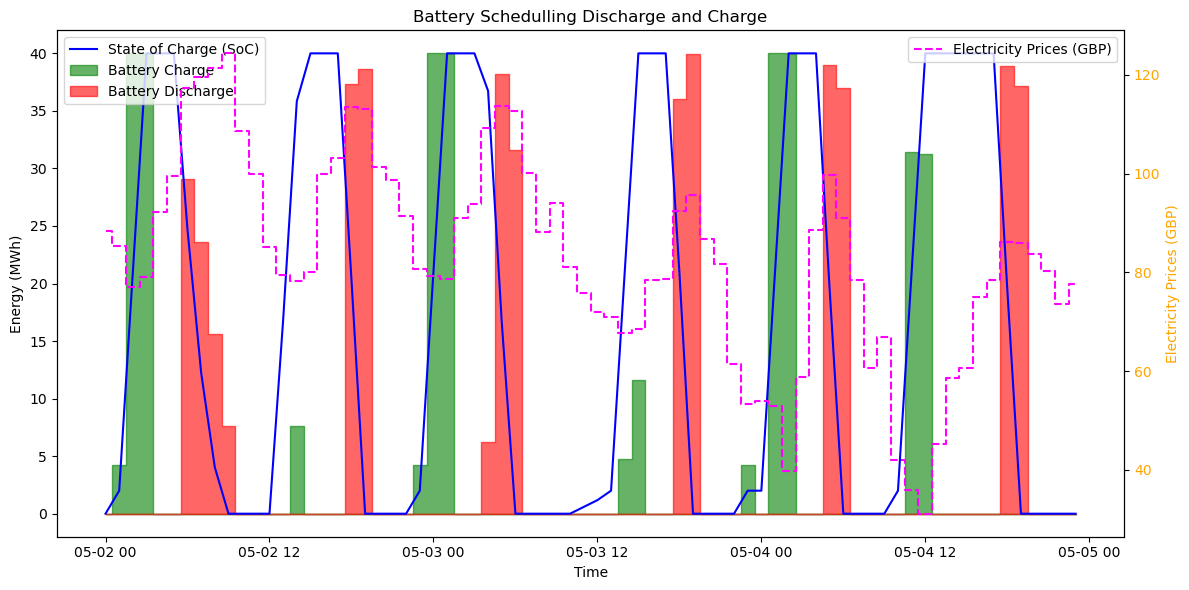

In [25]:
soc = network.storage_units_t.state_of_charge["battery"]
prices = prices_data.loc[network.snapshots, "prices"]
battery_discharge = network.storage_units_t.p_dispatch["battery"] * network.storage_units.at['battery', 'max_hours']
charge_flow = network.links_t.p0["grid_battery"] * network.storage_units.at['battery', 'max_hours']

# Calculate the maximum capacity of the battery
max_capacity = network.storage_units.at['battery', 'p_nom_opt'] * network.storage_units.at['battery', 'max_hours']

# Convert SoC to percentage
soc_percentage = (soc / max_capacity) * 100

start_date = "2022-05-02"
end_date = "2022-05-04"
    
# Filter the data for the specific time range
soc_filtered = soc.loc[start_date:end_date]
prices_filtered = prices.loc[start_date:end_date]
battery_charge_filtered = charge_flow.loc[start_date:end_date]
battery_discharge_filtered = battery_discharge.loc[start_date:end_date]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot State of Charge (SoC) percentage with the first y-axis
ax1.plot(soc_filtered.index, soc_filtered.values, label='State of Charge (SoC)', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('State of Charge (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Battery Charge and Discharge with the first y-axis
ax1.fill_between(battery_charge_filtered.index, 0, battery_charge_filtered.values, label='Battery Charge', color='green', step='mid', alpha=0.6)
ax1.fill_between(battery_discharge_filtered.index, 0, battery_discharge_filtered.values, label='Battery Discharge', color='red', step='mid', alpha=0.6)
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy (MWh)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Create a second y-axis to plot prices
ax2 = ax1.twinx()
ax2.step(prices_filtered.index, prices_filtered.values, label='Electricity Prices (GBP)', color='magenta', where='mid', linestyle="--")
ax2.set_ylabel('Electricity Prices (GBP)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Add a title and legend
plt.title(f'Battery Schedulling Discharge and Charge')
fig.tight_layout()

# Show the plot
plt.show()

In [35]:
# Extract the correct flows for charging and discharging
charge_flow = network.links_t.p0["grid_battery"]
discharge_flow = network.links_t.p1["battery_grid"]
prices = prices_data.loc[network.snapshots, "prices"]
solar_generation = network.generators_t.p["solar"]
p_dispatch = network.storage_units_t.p_dispatch["battery"]
p_store = network.storage_units_t.p_store["battery"]
initial_pv_nom_opt = network.generators.p_nom_opt['solar']

# Define the strike price (example value)
strike_price = 55
revenue_solar_cfd = (network.generators_t.p["solar"] * strike_price).sum()

#Arbitrage Scenario
# Calculate revenue from discharging
discharge_revenue = (p_dispatch * prices).sum()
# Calculate cost from charging
charge_cost = (charge_flow * prices).sum()

# Calculate net revenue from arbitrage
net_arbitrage_revenue = discharge_revenue - charge_cost

#Total Revenue
total_revenue_gross = revenue_solar_cfd + discharge_revenue
total_revenue = revenue_solar_cfd + net_arbitrage_revenue

In [37]:
# Assumptions
battery_capex_per_mw = 700000  
battery_replacement = 580000
# Operational Expenditure (OPEX)
battery_opex_per_mw_per_year = 15000 
# System Sizes
battery_capacity_mw = network.storage_units.at['battery', 'p_nom_opt']
battery_capacity_mwh = battery_capacity_mw * network.storage_units.at['battery', 'max_hours']
# Capital Expenditure (CAPEX)
battery_capex = (battery_capacity_mw * battery_capex_per_mw)
total_replacement = battery_capacity_mw * battery_replacement 
# Operational Expenditure (OPEX)
battery_opex = battery_capacity_mw * battery_opex_per_mw_per_year

Net Present Value (NPV): GBP-1917672.13
Internal Rate of Return (IRR): 3.50%
Payback Period: 19 years


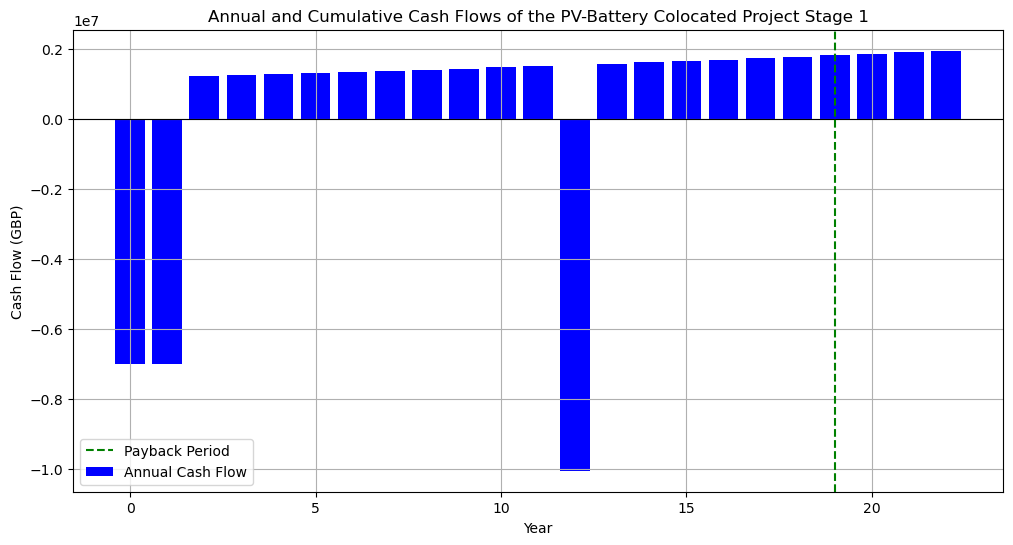

In [41]:
C_battery = battery_capex # Initial cost of battery in GBP
R_battery = total_replacement  # Replacement cost of battery in GBP
O_battery = battery_opex # Annual O&M cost of battery in GBP
discount_rate = 0.05  # Discount rate
battery_lifetime = 10  # Battery lifetime in years
project_lifetime = 20  # Project lifetime in years
construction_phase_years = 2
price_escalation_rate = 0.02  # Annual price escalation rate

# Provided annual revenues 
initial_arbitrage_revenue = net_arbitrage_revenue  # Initial arbitrage revenue in GBP

# Calculate escalated revenues
escalated_arbitrage_revenue = [initial_arbitrage_revenue * ((1 + price_escalation_rate) ** t) for t in range(project_lifetime + construction_phase_years)]
annual_revenue = [escalated_arbitrage_revenue[t] for t in range(project_lifetime + construction_phase_years)]

# Initialize cash flows list
cash_flows = []

# Construction phase (Years 0 and 1)
C_battery_annual = C_battery / construction_phase_years
cash_flows.append(-C_battery_annual)  # Year 0
cash_flows.append(-C_battery_annual)  # Year 1

# Operational phase (Years 2 to 16)
for t in range(2, battery_lifetime + construction_phase_years):
    cash_flow = annual_revenue[t-1] - O_battery
    cash_flows.append(cash_flow)

# Year 17 (Battery replacement, year 17 corresponds to year 16 of operation)
cash_flow = annual_revenue[battery_lifetime + construction_phase_years - 1] - (R_battery + O_battery)
cash_flows.append(cash_flow)

# Operational phase continued (Years 18 to 32)
for t in range(battery_lifetime + construction_phase_years + 1, project_lifetime + construction_phase_years + 1):
    cash_flow = annual_revenue[t-1] - O_battery
    cash_flows.append(cash_flow)

# Calculate NPV
npv = npf.npv(discount_rate, cash_flows)
print(f"Net Present Value (NPV): GBP{npv:.2f}")

# Calculate IRR
irr = npf.irr(cash_flows)
print(f"Internal Rate of Return (IRR): {irr * 100:.2f}%")

# Calculate Payback Period
cumulative_cash_flows = np.cumsum(cash_flows)
payback_period = np.argmax(cumulative_cash_flows >= 0)

# If the project never pays back, set payback period to None
if cumulative_cash_flows[payback_period] < 0:
    payback_period = None
print(f"Payback Period: {payback_period if payback_period is not None else 'Project does not pay back within the project lifetime'} years")

# Create a DataFrame for visualization
years = list(range(project_lifetime + construction_phase_years + 1))
df = pd.DataFrame({'Year': years, 'Cash Flow': cash_flows, 'Cumulative Cash Flow': cumulative_cash_flows})

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df['Year'], df['Cash Flow'], color='blue', label='Annual Cash Flow')
#plt.plot(df['Year'], df['Cumulative Cash Flow'], color='red', marker='o', linestyle='-', label='Cumulative Cash Flow')
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(payback_period, color='green', linestyle='--', label='Payback Period' if payback_period is not None else '')
plt.title('Annual and Cumulative Cash Flows of the PV-Battery Colocated Project Stage 1')
plt.xlabel('Year')
plt.ylabel('Cash Flow (GBP)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Extract the state of charge (SOC) after the first optimization
soc_first_optimization = arbitrage_state_of_charge

# Update the time series marginal costs to the BM prices
bm_prices = BM_prices_data['sell prices'].values
network.generators_t['marginal_cost'] = pd.DataFrame(bm_prices, index=network.snapshots, columns=['Backup Generator'])

network.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████████| 7/7 [00:00<00:00, 50.91it/s]
INFO:linopy.io: Writing time: 0.83s


Read LP format model from file /private/var/folders/ng/xnmfplc57n51cnr7htdqb6g00000gn/T/linopy-problem-yl75d6kj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ng/xnmfplc57n51cnr7htdqb6g00000gn/T/linopy-problem-yl75d6kj.lp


Reading time = 0.53 seconds


INFO:gurobipy:Reading time = 0.53 seconds


obj: 201483 rows, 78843 columns, 350403 nonzeros


INFO:gurobipy:obj: 201483 rows, 78843 columns, 350403 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 201483 rows, 78843 columns and 350403 nonzeros


INFO:gurobipy:Optimize a model with 201483 rows, 78843 columns and 350403 nonzeros


Model fingerprint: 0x3664bc70


INFO:gurobipy:Model fingerprint: 0x3664bc70


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [5e-03, 1e+06]


INFO:gurobipy:  Objective range  [5e-03, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-02, 2e+03]


INFO:gurobipy:  RHS range        [2e-02, 2e+03]


Presolve removed 157675 rows and 35047 columns


INFO:gurobipy:Presolve removed 157675 rows and 35047 columns


Presolve time: 0.42s


INFO:gurobipy:Presolve time: 0.42s


Presolved: 43808 rows, 43796 columns, 122664 nonzeros


INFO:gurobipy:Presolved: 43808 rows, 43796 columns, 122664 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 9.642e+04


INFO:gurobipy: AA' NZ     : 9.642e+04


 Factor NZ  : 4.818e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.818e+05 (roughly 40 MB of memory)


 Factor Ops : 6.116e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.116e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.06373411e+09 -2.12391452e+10  3.56e+02 3.50e-12  1.21e+07     1s


INFO:gurobipy:   0   4.06373411e+09 -2.12391452e+10  3.56e+02 3.50e-12  1.21e+07     1s


   1   4.04878229e+09 -1.97639701e+10  8.41e+01 3.30e+03  1.52e+06     1s


INFO:gurobipy:   1   4.04878229e+09 -1.97639701e+10  8.41e+01 3.30e+03  1.52e+06     1s


   2   3.97508777e+09 -9.73620847e+09  1.20e+01 2.53e+02  2.53e+05     1s


INFO:gurobipy:   2   3.97508777e+09 -9.73620847e+09  1.20e+01 2.53e+02  2.53e+05     1s


   3   3.92291716e+09  2.34817018e+09  1.44e+00 6.98e-10  1.85e+04     1s


INFO:gurobipy:   3   3.92291716e+09  2.34817018e+09  1.44e+00 6.98e-10  1.85e+04     1s


   4   3.70698646e+09  3.36521280e+09  1.14e-01 9.96e-11  3.92e+03     1s


INFO:gurobipy:   4   3.70698646e+09  3.36521280e+09  1.14e-01 9.96e-11  3.92e+03     1s


   5   3.65952611e+09  3.49695256e+09  5.31e-02 4.80e-11  1.86e+03     1s


INFO:gurobipy:   5   3.65952611e+09  3.49695256e+09  5.31e-02 4.80e-11  1.86e+03     1s


   6   3.62332439e+09  3.56897314e+09  2.16e-02 3.20e-10  6.21e+02     1s


INFO:gurobipy:   6   3.62332439e+09  3.56897314e+09  2.16e-02 3.20e-10  6.21e+02     1s


   7   3.61395379e+09  3.58418809e+09  1.34e-02 2.33e-10  3.40e+02     1s


INFO:gurobipy:   7   3.61395379e+09  3.58418809e+09  1.34e-02 2.33e-10  3.40e+02     1s


   8   3.61058410e+09  3.59326800e+09  1.08e-02 4.55e-13  1.98e+02     1s


INFO:gurobipy:   8   3.61058410e+09  3.59326800e+09  1.08e-02 4.55e-13  1.98e+02     1s


   9   3.60921715e+09  3.60461359e+09  2.11e-03 1.63e-09  5.26e+01     1s


INFO:gurobipy:   9   3.60921715e+09  3.60461359e+09  2.11e-03 1.63e-09  5.26e+01     1s


  10   3.60839476e+09  3.60634675e+09  1.08e-03 1.16e-10  2.34e+01     1s


INFO:gurobipy:  10   3.60839476e+09  3.60634675e+09  1.08e-03 1.16e-10  2.34e+01     1s


  11   3.60781635e+09  3.60693396e+09  4.21e-04 1.46e-09  1.01e+01     1s


INFO:gurobipy:  11   3.60781635e+09  3.60693396e+09  4.21e-04 1.46e-09  1.01e+01     1s


  12   3.60755613e+09  3.60714918e+09  1.68e-04 9.72e-11  4.65e+00     1s


INFO:gurobipy:  12   3.60755613e+09  3.60714918e+09  1.68e-04 9.72e-11  4.65e+00     1s


  13   3.60746341e+09  3.60728547e+09  7.91e-05 1.40e-09  2.03e+00     1s


INFO:gurobipy:  13   3.60746341e+09  3.60728547e+09  7.91e-05 1.40e-09  2.03e+00     1s


  14   3.60741476e+09  3.60733756e+09  3.47e-05 1.16e-10  8.82e-01     1s


INFO:gurobipy:  14   3.60741476e+09  3.60733756e+09  3.47e-05 1.16e-10  8.82e-01     1s


  15   3.60738898e+09  3.60736336e+09  4.03e-05 5.82e-11  2.93e-01     1s


INFO:gurobipy:  15   3.60738898e+09  3.60736336e+09  4.03e-05 5.82e-11  2.93e-01     1s


  16   3.60737827e+09  3.60737269e+09  9.29e-05 1.37e-09  6.43e-02     1s


INFO:gurobipy:  16   3.60737827e+09  3.60737269e+09  9.29e-05 1.37e-09  6.43e-02     1s


  17   3.60737512e+09  3.60737357e+09  6.61e-05 1.16e-10  1.81e-02     1s


INFO:gurobipy:  17   3.60737512e+09  3.60737357e+09  6.61e-05 1.16e-10  1.81e-02     1s


  18   3.60737450e+09  3.60737399e+09  3.22e-05 2.04e-10  6.00e-03     1s


INFO:gurobipy:  18   3.60737450e+09  3.60737399e+09  3.22e-05 2.04e-10  6.00e-03     1s


  19   3.60737425e+09  3.60737418e+09  1.06e-05 1.08e-09  9.56e-04     2s


INFO:gurobipy:  19   3.60737425e+09  3.60737418e+09  1.06e-05 1.08e-09  9.56e-04     2s


  20   3.60737421e+09  3.60737421e+09  3.60e-06 1.16e-10  7.33e-05     2s


INFO:gurobipy:  20   3.60737421e+09  3.60737421e+09  3.60e-06 1.16e-10  7.33e-05     2s


  21   3.60737421e+09  3.60737421e+09  1.54e-07 3.73e-11  2.44e-06     2s


INFO:gurobipy:  21   3.60737421e+09  3.60737421e+09  1.54e-07 3.73e-11  2.44e-06     2s


  22   3.60737421e+09  3.60737421e+09  1.50e-10 5.11e-08  2.44e-09     2s


INFO:gurobipy:  22   3.60737421e+09  3.60737421e+09  1.50e-10 5.11e-08  2.44e-09     2s


INFO:gurobipy:


Barrier solved model in 22 iterations and 1.67 seconds (1.00 work units)


INFO:gurobipy:Barrier solved model in 22 iterations and 1.67 seconds (1.00 work units)


Optimal objective 3.60737421e+09


INFO:gurobipy:Optimal objective 3.60737421e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5999 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    5999 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


     352 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:     352 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5881892e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.5881892e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    5974    3.6073742e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    5974    3.6073742e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 5974 iterations and 2.01 seconds (1.42 work units)


INFO:gurobipy:Solved in 5974 iterations and 2.01 seconds (1.42 work units)


Optimal objective  3.607374210e+09


INFO:gurobipy:Optimal objective  3.607374210e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78843 primals, 201483 duals
Objective: 3.61e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [45]:
# Create the model instance for the second optimization
model_bm = network.optimize.create_model()

In [47]:
# Define higher charging threshold and lower discharging threshold
higher_charge_threshold = BM_prices_data['buy prices'].quantile(0.75)  # Upper quartile for negative NIV
lower_discharge_threshold = BM_prices_data['sell prices'].quantile(0.50)  # Median for positive NIV
higher_charge_threshold, lower_discharge_threshold

(128.1925, 93.975)

In [49]:
def custom_constraints(network, snapshots):
    model = network.model
    variables_bm = model.variables
    charge_threshold = 128  # Threshold for charging
    discharge_threshold = 93  # Threshold for discharging
    battery_max_hours = network.storage_units.at["battery", "max_hours"]

    for t in snapshots:
        imbalance_volume = BM_prices_data['net imbalance volume'].loc[t]
        bm_sell_price = BM_prices_data['sell prices'].loc[t]
        bm_buy_price = BM_prices_data['buy prices'].loc[t]

        # Access the variables
        p_dispatch = variables_bm["StorageUnit-p_dispatch"].sel({"snapshot": t, "StorageUnit": "battery"})
        state_of_charge = variables_bm["StorageUnit-state_of_charge"].sel({"snapshot": t, "StorageUnit": "battery"})
        p_store = variables_bm["StorageUnit-p_store"].sel({"snapshot": t, "StorageUnit": "battery"})

        efficiency_dispatch = network.storage_units.at["battery", "efficiency_dispatch"]
        efficiency_store = network.storage_units.at["battery", "efficiency_store"]

        # Binary variables for conditions
        discharge_condition = (bm_sell_price >= discharge_threshold).astype(int)
        charge_condition = (bm_buy_price < charge_threshold).astype(int)

        if imbalance_volume > 0:
            # If NIV is positive, the battery should discharge only if sell price is above discharge threshold
            model.add_constraints((p_dispatch * battery_max_hours) <= (state_of_charge * efficiency_dispatch) * discharge_condition)
        
        elif imbalance_volume < 0:
            # If NIV is negative, the battery should charge only if buy price is below charge threshold
            model.add_constraints((p_store * battery_max_hours) <= (state_of_charge * efficiency_store) * charge_condition)

# Capture the state of charge from the first optimization
soc_initial = network.storage_units_t.state_of_charge["battery"].copy()

# Set the initial state of charge from the first optimization
soc_initial_value = soc_initial.iloc[0]

# Add the initial state of charge constraint
model_bm.add_constraints(model_bm.variables["StorageUnit-state_of_charge"].loc[:, "battery"].isel(snapshot=0) == soc_initial_value)

# Run the second stage optimization with custom constraints
network.optimize.solve_model(extra_functionality=custom_constraints, solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████████| 7/7 [00:00<00:00, 62.32it/s]
INFO:linopy.io: Writing time: 15.43s


Read LP format model from file /private/var/folders/ng/xnmfplc57n51cnr7htdqb6g00000gn/T/linopy-problem-bgmuvvlr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ng/xnmfplc57n51cnr7htdqb6g00000gn/T/linopy-problem-bgmuvvlr.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 210244 rows, 78843 columns, 367228 nonzeros


INFO:gurobipy:obj: 210244 rows, 78843 columns, 367228 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M1


INFO:gurobipy:CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 210244 rows, 78843 columns and 367228 nonzeros


INFO:gurobipy:Optimize a model with 210244 rows, 78843 columns and 367228 nonzeros


Model fingerprint: 0x106c4d5d


INFO:gurobipy:Model fingerprint: 0x106c4d5d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [5e-03, 1e+06]


INFO:gurobipy:  Objective range  [5e-03, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e-02, 2e+03]


INFO:gurobipy:  RHS range        [2e-02, 2e+03]


Presolve removed 166380 rows and 43523 columns


INFO:gurobipy:Presolve removed 166380 rows and 43523 columns


Presolve time: 0.29s


INFO:gurobipy:Presolve time: 0.29s


Presolved: 43864 rows, 35320 columns, 162824 nonzeros


INFO:gurobipy:Presolved: 43864 rows, 35320 columns, 162824 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 1


INFO:gurobipy: Dense cols : 1


 AA' NZ     : 2.507e+05


INFO:gurobipy: AA' NZ     : 2.507e+05


 Factor NZ  : 5.194e+05 (roughly 36 MB of memory)


INFO:gurobipy: Factor NZ  : 5.194e+05 (roughly 36 MB of memory)


 Factor Ops : 7.496e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.496e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.11228687e+09 -9.75825687e+09  1.19e+03 3.50e-12  1.49e+07     0s


INFO:gurobipy:   0   4.11228687e+09 -9.75825687e+09  1.19e+03 3.50e-12  1.49e+07     0s


   1   4.21899209e+09 -9.52188760e+09  4.76e+02 1.12e+04  6.30e+06     1s


INFO:gurobipy:   1   4.21899209e+09 -9.52188760e+09  4.76e+02 1.12e+04  6.30e+06     1s


   2   4.27349266e+09 -8.57071728e+09  1.24e+02 1.76e+03  1.32e+06     1s


INFO:gurobipy:   2   4.27349266e+09 -8.57071728e+09  1.24e+02 1.76e+03  1.32e+06     1s


   3   4.22481838e+09 -5.14289418e+09  9.42e+00 7.76e+01  1.68e+05     1s


INFO:gurobipy:   3   4.22481838e+09 -5.14289418e+09  9.42e+00 7.76e+01  1.68e+05     1s


   4   4.05377277e+09  1.75510644e+09  1.87e+00 9.17e+00  3.09e+04     1s


INFO:gurobipy:   4   4.05377277e+09  1.75510644e+09  1.87e+00 9.17e+00  3.09e+04     1s


INFO:gurobipy:


Barrier performed 4 iterations in 0.67 seconds (0.55 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.67 seconds (0.55 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 534


INFO:gurobipy:Extra simplex iterations after uncrush: 534


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   26117    3.6083568e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   26117    3.6083568e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 26117 iterations and 0.77 seconds (0.94 work units)


INFO:gurobipy:Solved in 26117 iterations and 0.77 seconds (0.94 work units)


Optimal objective  3.608356808e+09


INFO:gurobipy:Optimal objective  3.608356808e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78843 primals, 210244 duals
Objective: 3.61e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, con0, con1, con2, con3, con4, con5, con6, con7, con8, con9, con10, con11, con12, con13, con14, con15, con16, con17, con18, con19, con20, con21, con22, con23, con24, con25, con26, con27, con28, con29, con30, con31, con32, con33, con34, con35, con36, con37, con38, con39, con40, con41, con42, con43, con44, con45, con46, con47, con48, con49, con50, con51, 

('ok', 'optimal')

In [51]:
# Flows
solar_grid_flow2 = network.links_t.p0["solar_grid"]
solar_battery_flow2 = network.links_t.p0["solar_battery"]
battery_grid_flow2 = network.links_t.p0["battery_grid"]
grid_battery_flow2 = network.links_t.p0["grid_battery"]
soc2 = network.storage_units_t.state_of_charge["battery"]
soc_percentage2 = (soc2 / battery_capacity) * 100

# Total energy flow
total_solar_grid2 = solar_grid_flow2.sum()
total_solar_battery2 = solar_battery_flow2.sum()
total_battery_grid2 = battery_grid_flow2.sum()
total_grid_battery2 = grid_battery_flow2.sum()

# Total energy generated by PV
energy_generated_pv2 = network.generators_t.p["solar"]
total_energy_generated_pv2 = network.generators_t.p["solar"].sum()
# Total energy discharged by the battery over the year (in MWh)
total_energy_discharged_battery2 = network.storage_units_t.p_dispatch["battery"].sum()
# Total energy charged by the battery over the year (in MWh)
total_energy_charged_battery2 = network.storage_units_t.p_store["battery"].sum()

BM_state_of_charge = network.storage_units_t.state_of_charge["battery"].copy()
BM_p_dispatch = network.storage_units_t.p_dispatch["battery"].copy()
BM_p_store = network.storage_units_t.p_store["battery"].copy()

# Create a DataFrame to save the results
results = {
    "Total Solar to Grid (MWh)": [total_solar_grid2],
    "Total Solar to Battery (MWh)": [total_solar_battery2],
    "Total Battery to Grid (MWh)": [total_battery_grid2],
    "Total Grid to Battery (MWh)": [total_grid_battery2],
    "Total Energy Generated by PV (MWh)": [total_energy_generated_pv2],
    "Total Energy Discharged by Battery (MWh)": [BM_p_store.sum()],
    "Total Energy Charged by Battery (MWh)": [total_energy_charged_battery2]
}

results_df = pd.DataFrame(results)

# Save the state of charge, dispatch, and store data to separate sheets
with pd.ExcelWriter("3busesBM2023BM.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="Summary", index=False)
    energy_generated_pv2.to_frame(name="Solar generated").to_excel(writer, sheet_name="Solar generated")
    solar_grid_flow2.to_frame(name="Solar to Grid (MW)").to_excel(writer, sheet_name="Solar to Grid")
    solar_battery_flow2.to_frame(name="Solar to Battery (MW)").to_excel(writer, sheet_name="Solar to Battery")
    battery_grid_flow2.to_frame(name="Battery to Grid (MW)").to_excel(writer, sheet_name="Battery to Grid")
    grid_battery_flow2.to_frame(name="Grid to Battery (MW)").to_excel(writer, sheet_name="Grid to Battery")
    soc2.to_frame(name="State of Charge (MWh)").to_excel(writer, sheet_name="State of Charge")
    soc_percentage2.to_frame(name="State of Charge (%)").to_excel(writer, sheet_name="State of Charge %")
    BM_p_dispatch.to_frame(name="Battery Dispatch (MW)").to_excel(writer, sheet_name="Battery Dispatch")
    BM_p_store.to_frame(name="Battery Store (MW)").to_excel(writer, sheet_name="Battery Store")

In [69]:
solar_revenue_BM = total_solar_grid2 * strike_price
bm_sell_prices = BM_prices_data['sell prices']
bm_buy_prices = BM_prices_data['buy prices']

discharge_bm = (BM_p_dispatch * bm_buy_prices).sum()
grid_battery_flow = network.links_t.p1["grid_battery"]
bm_link_store_cost = (grid_battery_flow * bm_buy_prices).sum()

bm_revenue_fix = discharge_bm - -bm_link_store_cost 
bm_revenue_fix_30 = bm_revenue_fix * 0.3

print("Solar Revenue BM: £", solar_revenue_BM)
print("BM Dispatch Revenue: £", discharge_bm)
print("BM Store Link Cost: £", bm_link_store_cost)
print("BM Revenue Fix: £", bm_revenue_fix)
print("BM Revenue Fix 30%: £", bm_revenue_fix_30)

Solar Revenue BM: £ 780223.3042215311
BM Dispatch Revenue: £ 4092483.01120296
BM Store Link Cost: £ -1562091.9119486928
BM Revenue Fix: £ 2530391.0992542673
BM Revenue Fix 30%: £ 759117.3297762802


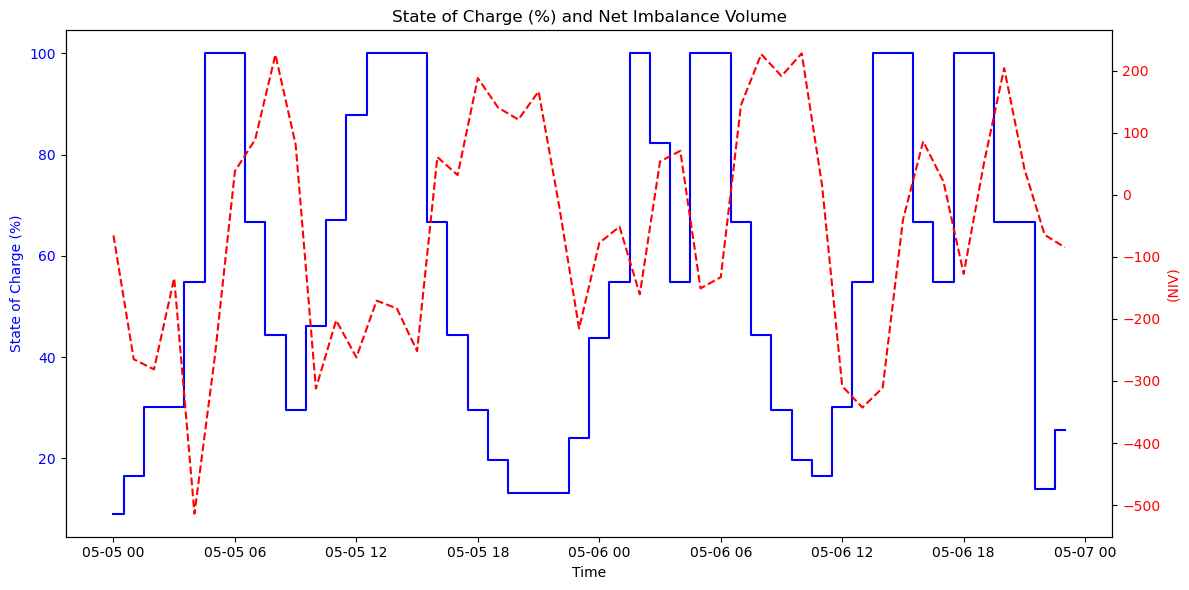

In [71]:
soc = BM_state_of_charge
NIV = BM_prices_data.loc[network.snapshots, "net imbalance volume"]

# Calculate the maximum capacity of the battery
max_capacity = network.storage_units.at['battery', 'p_nom_opt'] * network.storage_units.at['battery', 'max_hours']

# Convert SoC to percentage
soc_percentage = (soc / max_capacity) * 100

start_date = "2022-05-05"
end_date = "2022-05-06"
    
# Filter the data for the specific time range
soc_filtered = soc_percentage.loc[start_date:end_date]
prices_filtered = NIV.loc[start_date:end_date]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot State of Charge (SoC) percentage with the first y-axis
ax1.step(soc_filtered.index, soc_filtered.values, label='State of Charge (SoC) %', color='blue', where='mid', linestyle="-")
ax1.set_xlabel('Time')
ax1.set_ylabel('State of Charge (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot prices
ax2 = ax1.twinx()
ax2.plot(prices_filtered.index, prices_filtered.values, label='Electricity Prices (GBP/MWh)', color='red', linestyle="--")
ax2.set_ylabel('(NIV)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and legend
plt.title(f'State of Charge (%) and Net Imbalance Volume')
fig.tight_layout()

# Show the plot
plt.show()

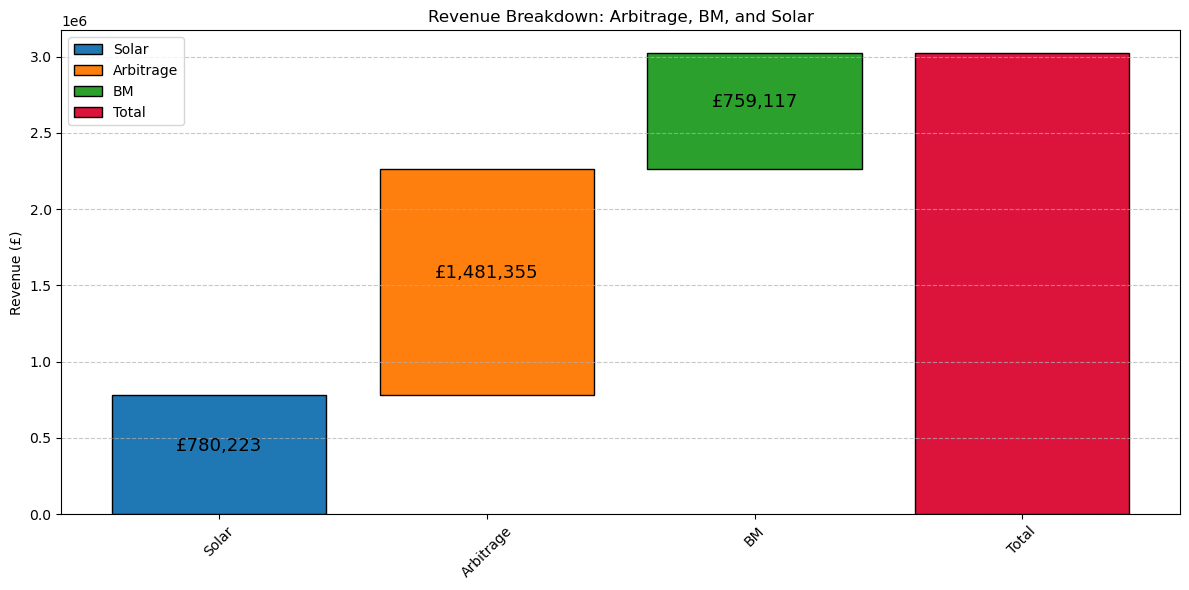

In [73]:
# Arbitrage and BM revenues
arbitrage_revenue = net_arbitrage_revenue
bm_net_revenue = bm_revenue_fix_30 
solar_revenue = solar_revenue_BM
Total = arbitrage_revenue + bm_net_revenue + solar_revenue

# Data for the waterfall chart
categories = ['Solar', 'Arbitrage', 'BM','Total']
values = [solar_revenue, arbitrage_revenue, bm_net_revenue, Total]

# Calculate cumulative values
cumulative_values = np.cumsum([0] + values[:-1]).tolist()
cumulative_values.append(cumulative_values[-1] + values[-1])

# Waterfall chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
for i, (category, value, cumulative_value) in enumerate(zip(categories, values, cumulative_values)):
    if i == len(categories) - 1:
        ax.bar(category, value, color='crimson', edgecolor='black', label=category)
    else:
        ax.bar(category, value, bottom=cumulative_value, edgecolor='black', label=category)

# Plot cumulative values
for i, (category, cumulative_value) in enumerate(zip(categories, cumulative_values)):
    if i < len(categories) - 1:
        ax.text(i, cumulative_value + values[i] / 2, f'£{values[i]:,.0f}', ha='center', va='bottom', color='black', fontsize=13)

# Formatting
ax.set_title('Revenue Breakdown: Arbitrage, BM, and Solar')
ax.set_ylabel('Revenue (£)')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [75]:
# Assumptions
battery_capex_per_mw = 700000 # $/MW for battery storage
battery_replacement = 580000
# Operational Expenditure (OPEX)
battery_opex_per_mw_per_year = 15000 # $/MW/year for battery storage
# System Sizes
battery_capacity_mw = network.storage_units.at['battery', 'p_nom_opt']
battery_capacity_mwh = battery_capacity_mw * network.storage_units.at['battery', 'max_hours']

# Capital Expenditure (CAPEX)
battery_capex = (battery_capacity_mw * battery_capex_per_mw)
total_replacement = battery_replacement * battery_capacity_mw

# Operational Expenditure (OPEX)
battery_opex = battery_capacity_mw * battery_opex_per_mw_per_year

Net Present Value (NPV): GBP9290331.38
Internal Rate of Return (IRR): 11.21%
Payback Period: 8 years


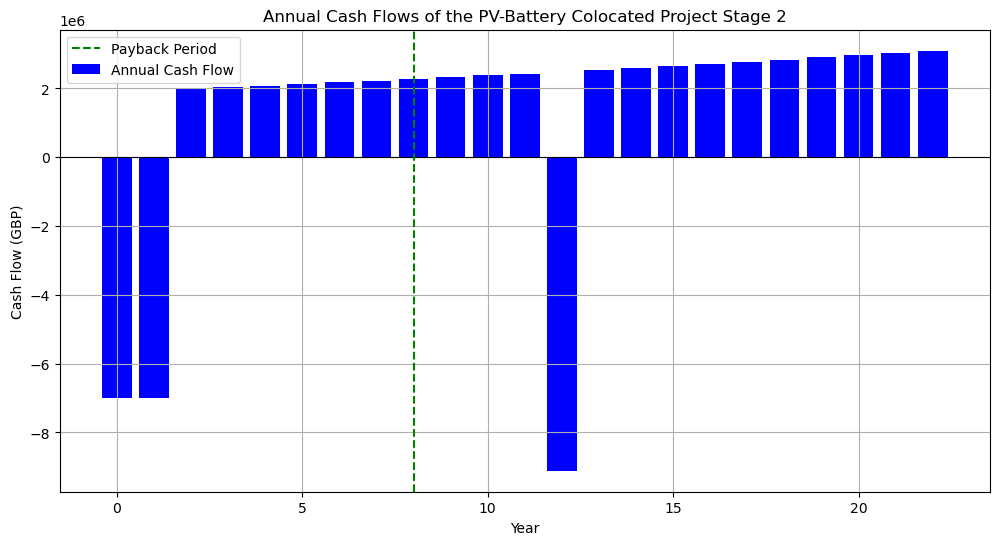

In [77]:
C_battery = battery_capex # Initial cost of battery in GBP
R_battery = total_replacement # Replacement cost of battery in GBP
O_battery = battery_opex # Annual O&M cost of battery in GBP
discount_rate = 0.05 # Discount rate
battery_lifetime = 10  # Battery lifetime in years
project_lifetime = 20  # Project lifetime in years
construction_phase_years = 2
price_escalation_rate = 0.02  # Annual price escalation rate

# Provided annual revenues
initial_arbitrage_revenue = net_arbitrage_revenue  # Initial arbitrage revenue in GBP
initial_BM_revenue = bm_revenue_fix * 0.3

# Calculate escalated revenues
escalated_arbitrage_revenue = [initial_arbitrage_revenue * ((1 + price_escalation_rate) ** t) for t in range(project_lifetime + construction_phase_years)]
escalated_BM_revenue = [initial_BM_revenue * ((1 + price_escalation_rate) ** t) for t in range(project_lifetime + construction_phase_years)]
annual_revenue = [escalated_BM_revenue[t] + escalated_arbitrage_revenue[t] for t in range(project_lifetime + construction_phase_years)]

# Initialize cash flows list
cash_flows = []

# Construction phase (Years 0 and 1)
C_battery_annual = C_battery / construction_phase_years
cash_flows.append(-(C_battery_annual))  # Year 0
cash_flows.append(-C_battery_annual)  # Year 1

# Operational phase (Years 2 to 16)
for t in range(2, battery_lifetime + construction_phase_years):
    cash_flow = annual_revenue[t-1] - O_battery
    cash_flows.append(cash_flow)

# Year 17 (Battery replacement, year 17 corresponds to year 16 of operation)
cash_flow = annual_revenue[battery_lifetime + construction_phase_years - 1] - (R_battery + O_battery)
cash_flows.append(cash_flow)

# Operational phase continued (Years 18 to 32)
for t in range(battery_lifetime + construction_phase_years + 1, project_lifetime + construction_phase_years + 1):
    cash_flow = annual_revenue[t-1] - O_battery
    cash_flows.append(cash_flow)

# Calculate NPV
npv = npf.npv(discount_rate, cash_flows)
print(f"Net Present Value (NPV): GBP{npv:.2f}")

# Calculate IRR
irr = npf.irr(cash_flows)
print(f"Internal Rate of Return (IRR): {irr * 100:.2f}%")

# Calculate Payback Period
cumulative_cash_flows = np.cumsum(cash_flows)
payback_period = np.argmax(cumulative_cash_flows >= 0)

# If the project never pays back, set payback period to None
if cumulative_cash_flows[payback_period] < 0:
    payback_period = None

print(f"Payback Period: {payback_period if payback_period is not None else 'Project does not pay back within the project lifetime'} years")

# Create a DataFrame for visualization
years = list(range(project_lifetime + construction_phase_years + 1))
df = pd.DataFrame({'Year': years, 'Cash Flow': cash_flows, 'Cumulative Cash Flow': cumulative_cash_flows})

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(df['Year'], df['Cash Flow'], color='blue', label='Annual Cash Flow')
#plt.plot(df['Year'], df['Cumulative Cash Flow'], color='red', marker='o', linestyle='-', label='Cumulative Cash Flow')
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(payback_period, color='green', linestyle='--', label='Payback Period' if payback_period is not None else '')
plt.title('Annual Cash Flows of the PV-Battery Colocated Project Stage 2')
plt.xlabel('Year')
plt.ylabel('Cash Flow (GBP)')
plt.legend()
plt.grid(True)
plt.show()

,Base Case Value,-10%,+10%,NPV -10%,NPV +10%,NPV Change -10%,NPV Change +10%,NPV Change % -10%,NPV Change % +10%,Range
price_escalation_rate,0.020,0.0180,0.0220,1.766347e+06,2.689682e+06,-4.563041e+05,4.670315e+05,-20.529724,21.012365,41.542090
battery_opex_per_mw_per_year,15000.000,13500.0000,16500.0000,2.588970e+06,1.856332e+06,3.663186e+05,-3.663186e+05,16.481160,-16.481160,32.962319
battery_degradation_rate,0.025,0.0225,0.0275,2.835586e+06,1.628061e+06,6.129353e+05,-5.945900e+05,27.576769,-26.751390,54.328160
discount_rate,0.050,0.0450,0.0550,2.913979e+06,1.581555e+06,6.913282e+05,-6.410961e+05,31.103770,-28.843762,59.947531
battery_capex_per_mw,700000.000,630000.0000,770000.0000,3.589318e+06,8.559843e+05,1.366667e+06,-1.366667e+06,61.488137,-61.488137,122.976275
battery_capacity_mw,20.000,18.0000,22.0000,4.601568e+06,-1.562658e+05,2.378917e+06,-2.378917e+06,107.030603,-107.030603,214.061207


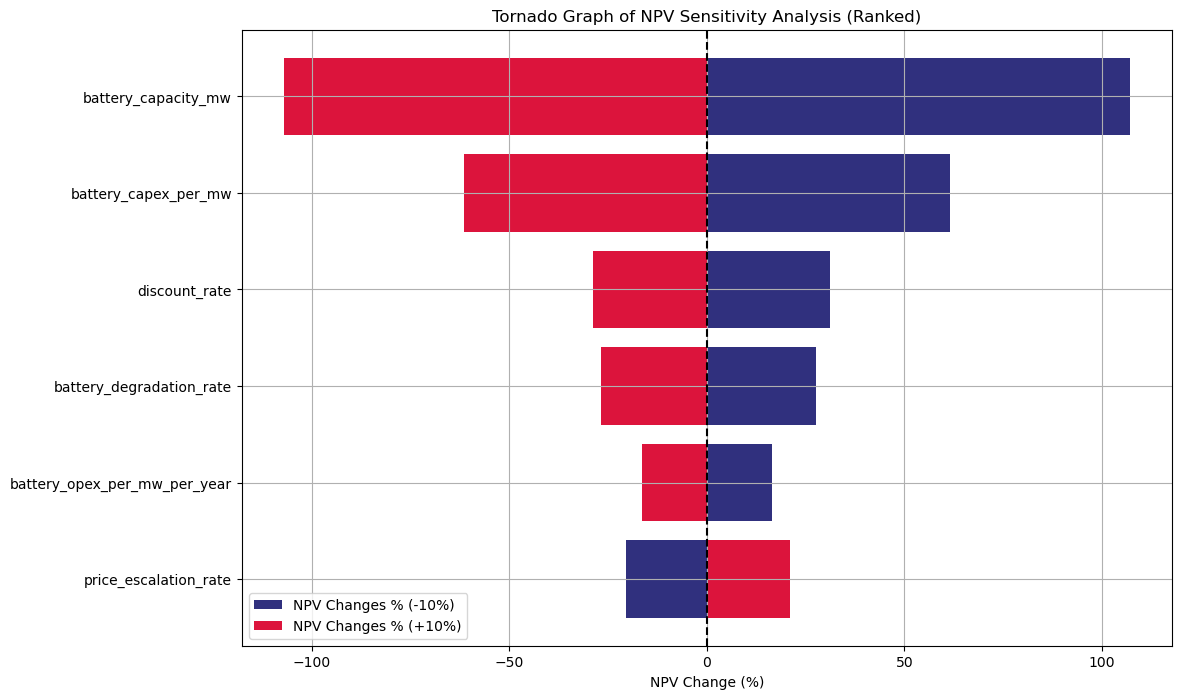

In [79]:
# Define the base case parameters
base_params = {
    'discount_rate': 0.05,
    'battery_capex_per_mw': 700000, 
    'battery_capacity_mw': 20,  # Example value, replace with actual value
    'battery_opex_per_mw_per_year': 15000,
    'battery_efficiency': 0.85,  # Initial efficiency
    'battery_degradation_rate': 0.025,  # 2.5% per year
    'price_escalation_rate': 0.02,
}

# Define the necessary project variables
battery_replacement = 580000  # Example value, replace with actual value
initial_arbitrage_revenue = net_arbitrage_revenue # Example value, replace with actual value
initial_BM_revenue = bm_revenue_fix * 0.3  # Example value, replace with actual value
project_lifetime = 20
construction_phase_years = 2
battery_lifetime = 10

def calculate_npv(params):
    battery_capex = params['battery_capacity_mw'] * params['battery_capex_per_mw']
    total_capex = battery_capex
    total_replacement = battery_replacement * params['battery_capacity_mw']

    battery_opex = params['battery_capacity_mw'] * params['battery_opex_per_mw_per_year']
    total_opex = battery_opex

    #escalated_solar_revenue_cfd = [initial_solar_revenue_cfd * ((1 + params['price_escalation_rate']) ** t) for t in range(project_lifetime + construction_phase_years)]
    escalated_arbitrage_revenue = [initial_arbitrage_revenue * ((1 + params['price_escalation_rate']) ** t) for t in range(project_lifetime + construction_phase_years)]
    escalated_BM_revenue = [initial_BM_revenue * ((1 + params['price_escalation_rate']) ** t) for t in range(project_lifetime + construction_phase_years)]
    
    # Adjust revenues for degradation
    annual_revenue = []
    for t in range(project_lifetime + construction_phase_years):
        battery_degradation = (1 - params['battery_degradation_rate']) ** t
        adjusted_arbitrage_revenue = escalated_arbitrage_revenue[t] * battery_degradation
        adjusted_BM_revenue = escalated_BM_revenue[t] * battery_degradation
        annual_revenue.append(adjusted_BM_revenue + adjusted_arbitrage_revenue)

    cash_flows = []
    C_battery_annual = battery_capex / construction_phase_years
    cash_flows.append(-(C_battery_annual))  # Year 0
    cash_flows.append(-C_battery_annual)  # Year 1

    for t in range(2, battery_lifetime + construction_phase_years):
        cash_flow = annual_revenue[t-1] - battery_opex
        cash_flows.append(cash_flow)

    cash_flow = annual_revenue[battery_lifetime + construction_phase_years - 1] - (total_replacement + battery_opex)
    cash_flows.append(cash_flow)

    for t in range(battery_lifetime + construction_phase_years + 1, project_lifetime + construction_phase_years + 1):
        cash_flow = annual_revenue[t-1] - battery_opex
        cash_flows.append(cash_flow)

    npv = npf.npv(params['discount_rate'], cash_flows)
    return npv

# Calculate the base case NPV
base_npv = calculate_npv(base_params)

# Define the parameters for sensitivity analysis
parameters = [
    #'battery_efficiency',
    'price_escalation_rate',
    'battery_opex_per_mw_per_year',
    'battery_degradation_rate',
    'discount_rate',
    'battery_capex_per_mw',
    'battery_capacity_mw'
]

# Calculate NPVs for +10% and -10% changes
sensitivity_data = []

for param in parameters:
    low_params = base_params.copy()
    high_params = base_params.copy()
    low_params[param] *= 0.9
    high_params[param] *= 1.1
    low_npv = calculate_npv(low_params)
    high_npv = calculate_npv(high_params)
    low_change = low_npv - base_npv
    high_change = high_npv - base_npv
    low_change_percent = (low_change / base_npv) * 100
    high_change_percent = (high_change / base_npv) * 100
    sensitivity_data.append([
        base_params[param],  # Base value
        low_params[param],  # -10%
        high_params[param],  # +10%
        low_npv,  # NPV at -10%
        high_npv,  # NPV at +10%
        low_change,  # NPV change at -10%
        high_change,  # NPV change at +10%
        low_change_percent,  # NPV change % at -10%
        high_change_percent  # NPV change % at +10%
    ])

# Create DataFrame for the sensitivity analysis results
sensitivity_df = pd.DataFrame(sensitivity_data, columns=[
    'Base Case Value', '-10%', '+10%', 'NPV -10%', 'NPV +10%', 'NPV Change -10%', 'NPV Change +10%', 'NPV Change % -10%', 'NPV Change % +10%'
], index=parameters)

# Calculate the range of changes
sensitivity_df['Range'] = sensitivity_df[['NPV Change % -10%', 'NPV Change % +10%']].max(axis=1) - sensitivity_df[['NPV Change % -10%', 'NPV Change % +10%']].min(axis=1)


# Save the DataFrame to an Excel file
sensitivity_df.to_excel('npv_sensitivity_analysis_ranked.xlsx', sheet_name='Sensitivity Analysis')

# Display DataFrame to user
from IPython.display import display
display(sensitivity_df)

# Plot the tornado graph
plt.figure(figsize=(12, 8))

# Plot negative changes
plt.barh(sensitivity_df.index, sensitivity_df['NPV Change % -10%'], color='midnightblue', alpha=0.9, label='NPV Changes % (-10%)')

# Plot positive changes
plt.barh(sensitivity_df.index, sensitivity_df['NPV Change % +10%'], color='crimson', alpha=1, label='NPV Changes % (+10%)')

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('NPV Change (%)')
plt.title('Tornado Graph of NPV Sensitivity Analysis (Ranked)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
